## Tutorial - 0: Continuous Forward Schrodinger

Welcome to our first tutorial on Physics-Informed Neural Networks (PINNs) using `PyTorch Lightning` and our new package, **`pinnstf2`**! This guide aims to introduce you to the integration of deep learning and scientific computing via PINNs, which embed physical laws into neural network training.

#### Overview:

- **Mesh Generation and Sampling:** Understanding how to create and use meshes for training PINNs, crucial for defining the domain of our problem.
- **Neural Network Model with PINNs:** How to build and structure a neural network for physical law integration.
- **Physical Laws in Neural Networks:** Detailing the implementation of differential equations within the network using `pde_fn` and `output_fn`.
- **Training and Validation:** Utilizing PyTorch Lightning’s Trainer to train our model, including defining the training data, initial conditions, and handling boundary conditions.
- **Results Visualization:** Saving and analyzing the outcomes of your PINN models.

#### Install `pinnstf2`

In [ ]:
!pip install pinnstf2

#### Import Libraries

In [1]:
from typing import Dict

import tensorflow as tf
import numpy as np

import pinnstf2

2023-11-06 19:18:43.416793: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 19:18:43.418398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 19:18:43.450041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 19:18:43.450901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 19:18:44.068175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Define Mesh

Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnstf2`, there are primarily two approaches to define this mesh:


- **Defining Time and Spatial Domains Separately:** Here, we use `pinnstf2.data.TimeDomain` and `pinnstf2.data.Interval` for creating 1-D spatial domains. These domains are then used to define a `pinnstf2.data.Mesh`.

- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnstf2.data.PointCloud`.

Both approaches should ideally yield the same results.

#### Option 1: Defining Mesh with Separate Time and Spatial Domains

We start by defining a function to read and preprocess the solution data from a file. The output should be a dictionary.

In [2]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in Mesh class.
    """

    data = pinnstf2.utils.load_data(root_path, "NLS.mat")
    exact = data["uu"]
    exact_u = np.real(exact) # N x T
    exact_v = np.imag(exact) # N x T
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T
    return {"u": exact_u, "v": exact_v, "h": exact_h}

Now, define the time and spatial domains for mesh generation. The choice of these parameters depends on the specific problem being solved and should be set accordingly.

In [3]:
time_domain = pinnstf2.data.TimeDomain(t_interval=[0, 1.57079633], t_points = 201)
spatial_domain = pinnstf2.data.Interval(x_interval= [-5, 4.9609375], shape = [256, 1])

The mesh is then defined using the time and spatial domains along with the read_data_fn function. 

In [4]:
mesh = pinnstf2.data.Mesh(root_dir='data',
                            read_data_fn=read_data_fn,
                            spatial_domain = spatial_domain,
                            time_domain = time_domain)

#### Option 2: Using Point Clouds

For scenarios where the spatial and temporal data along with solutions are directly available (e.g., from experimental measurements), we can create a mesh using `pinnstf2.data.PointCloud`.

**Note:** It's crucial to format the spatial and temporal domain dimensions correctly. Specifically:

- **Spatial Domain:** Each axis should be structured in the shape of $(N \times 1)$, where $N$ represents the number of spatial points.
- **Time Domain:** This should be formatted as $(T \times 1)$, where $T$ indicates the number of time steps.
- **Solution Data:** Each solution variable (e.g., temperature, velocity) should be in the shape of $(N \times T)$, aligning with the spatial and temporal points.

In [5]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in PointCloud class.
    """

    data = pinnstf2.utils.load_data(root_path, "NLS.mat")

    x = data["x"].T  # N x 1
    t = data["tt"].T  # T x 1
    
    exact = data["uu"]
    exact_u = np.real(exact) # N x T
    exact_v = np.imag(exact) # N x T
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T
    
    return pinnstf2.data.PointCloudData(
            spatial=[x], time=[t], solution={"u": exact_u, "v": exact_v, "h": exact_h}
    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [6]:
mesh = pinnstf2.data.PointCloud(root_dir='./data',
                                  read_data_fn=read_data_fn)

### Define Train datasets

For solving Schrodinger PDE, we have:
- Initial condition
- Periodic boundary condition
- Collection points for the PDE.

#### Initial Condition

Let's start with initial condition of the Schrodinger.
$$ u(0, x) = 2 \text{sech}(x) $$
$$ v(0, x) = 0 $$

For defining initial condition, again we have two options.

- **Sample from the data.**
- **Defining a function for calculating initial condition.**

##### Set number of samples

In [7]:
N0 = 50

##### Option 1: Sample from the data

In [8]:
in_c = pinnstf2.data.InitialCondition(mesh = mesh,
                                        num_sample = N0,
                                        solution = ['u', 'v'])

2023-11-06 19:19:00.681512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


##### Option 2: Defining a function for calculating initial condition

The input of `initial_fun` should be the same as spatial domain of the problem.

In [9]:
def initial_fun(x):
    return {'u': 2*1/np.cosh(x), 'v': np.zeros_like(x)}

In [10]:
in_c = pinnstf2.data.InitialCondition(mesh = mesh,
                                        num_sample = N0,
                                        initial_fun = initial_fun,
                                        solution = ['u', 'v'])

The `solution` attribute in `pinnstf2.data.InitialCondition` specifies the solutions (`u` and `v` in our case) to be sampled for initial conditions.

#### Periodic Boundary Condition

The `pinnstf2.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Schrödinger equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.


$$ u(t,-5) = u(t, 5), $$
$$ v(t,-5) = v(t, 5), $$ 
$$ u_x(t,-5) = u_x(t, 5),$$
$$ v_x(t,-5) = v_x(t, 5) $$

In [11]:
N_b = 50
pe_b = pinnstf2.data.PeriodicBoundaryCondition(mesh = mesh,
                                                 num_sample = 50,
                                                 derivative_order = 1,
                                                 solution = ['u', 'v'])

#### Mesh Sampler for collection points and solutions

In our problem, the partial differential equations (PDEs) governing the dynamics are given by:

$$ f_u := u_t + 0.5v_{xx} + v(u^2 +v^2),$$
$$ f_v := v_t + 0.5u_{xx} + u(u^2 +v^2) $$

To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstf2.data.MeshSampler` for this purpose, specifying the following:

- **Number of Sample Points (N_f):** We choose to sample 20,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.
- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.
- **Collection Points:** We define `['f_u', 'f_v']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.

Here's the code to implement this sampler:

In [12]:
N_f = 20000
me_s = pinnstf2.data.MeshSampler(mesh = mesh,
                                   num_sample = N_f,
                                   collection_points = ['f_v', 'f_u'])

### Define Validation dataset

For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `u`, `v`, and `h`.

**Note:** If `num_sample` is not specified, the sampler will use the entire mesh for data sampling.

In [13]:
val_s = pinnstf2.data.MeshSampler(mesh = mesh,
                                    solution = ['u', 'v', 'h'])

### Define Neural Networks

Here, we try to define a neural network for solving the problem. For defining a neural network, we should set number of layers and the name of the outputs. Also, domain bounds should be defined. The `lb` and `ub` parameters represent the lower and upper bounds of the spatial-temporal domain, helping in normalizing inputs to the network. Therefore, the inputs of this network are `x` and `t`, and the outputs of this network are `u` and `v`.

In [14]:
net = pinnstf2.models.FCN(layers = [2, 100, 100, 100, 100, 2],
                            output_names = ['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 30802 (120.32 KB)
Trainable params: 30802 (120.

### Define `pde_fn` and `output_fn` functions

Now, we define `pde_fn` and `output_fn`.
- **`output_fn`:** is applied to the network's output, adding any necessary post-processing computations. For example, in our case, `h(x,t) = u(x,t)**2 + v(x,t)**2`, thus, we define this equation in `output_fn`.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points. 

#### `output_fn` function

**Note:** `output_fn` should always have these inputs:
- **Outputs:** It is output of the network. In our case, this dictionary should have two output: `u` and `v`.
- **Spatial domains:** These are the spatial domain variables. In our case, because our problem has 1-D spatial domain, the input just have `x`. For example, if we had 2-D space, we need another input for that dimention. For example, the inputs from `(outputs, x, t)` will be changed to `(outputs, x, y, t)`.
- **Time domin:** The last input of `output_fn` function always should be time.

In [15]:
def output_fn(outputs: Dict[str, tf.Tensor],
              x: tf.Tensor,
              t: tf.Tensor):
    """Define `output_fn` function that will be applied to outputs of net."""

    outputs["h"] = tf.sqrt(outputs["u"] ** 2 + outputs["v"] ** 2)

    return outputs

#### `pde_fn` function

The inputs are similar to `output_fn`. Only if we have extra variables for training (i.g. in inverse problems), we should add input at the end of inputs. For example, `(outputs, x, t)` will be `(outputs, x, t, extra_variable)`. `extra_variable` is always a dictionary.

In [16]:
def pde_fn(outputs: Dict[str, tf.Tensor],
           x: tf.Tensor,
           t: tf.Tensor):   
    """Define the partial differential equations (PDEs)."""
    
    u_x, u_t = pinnstf2.utils.gradient(outputs["u"], [x, t])
    v_x, v_t = pinnstf2.utils.gradient(outputs["v"], [x, t])

    u_xx = pinnstf2.utils.gradient(u_x, x)[0]
    v_xx = pinnstf2.utils.gradient(v_x, x)[0]

    outputs["f_u"] = u_t + 0.5 * v_xx + (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["v"]
    outputs["f_v"] = v_t - 0.5 * u_xx - (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["u"]

    return outputs

### Define PINNDataModule and PINNModule

To integrate with Lightning, we utilize two specialized modules:

- `PINNDataModule` (inherited from `LightningDataModule`) manages data.
- `PINNModule` (derived from `LightningModule`) handles the model, compilation, and various enhancements like AMP.

#### Define `PINNDataModule`
Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [17]:
train_datasets = [me_s, in_c, pe_b]
val_dataset = val_s
datamodule = pinnstf2.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

#### Define `PINNModule`

`PINNModule` handle several things. Here, we will explore the inputs of this class:

- **net:**  The neural network model to be used for approximating solutions.
- **pde_fn:** The partial differential equation (PDE) function defining the PDE to solve.
- **optimizer:**  (Optional) The optimizer used for training the neural network. The default is Adam
- **loss_fn:** (Optional) The loss function to use, either "sse" or "mse". The default is "sse".
- **extra_variables:** (Optional) Extra variables in inverse problems. The default is None.
- **output_fn:** (Optional) function to process the model's output. The default is None.
- **runge_kutta:** (Optional) Runge-Kutta method for solving PDEs in discrete mode. The default is None.
- **jit_compile:** (Optional) Flag to enable JIT compilation. The default is True.
- **amp:** (Optional) Flag to enable Automatic Mixed Precision (AMP). The default is False.
- **dtype:** (Optional) Data type to be used for the computations. Default is 'float32'.

In this example, we initalize `PINNModule` with defined variables. We set Adam optimizer and try to compile the model with CUDA Graph. The loss function here is Mean Square Error (MSE).

In [18]:
model = pinnstf2.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   output_fn = output_fn,
                                   loss_fn = 'mse')

### Setting Up the Trainer

For training our model, we write a custom trainer. Arguments that you can set are:

- **max_epochs:** Maximum number of training epochs.
- **check_val_every_n_epoch:** (Optional) Frequency of validation checks within epochs. Defualt is 1.
- **enable_progress_bar:** (Optional) Flag to enable/disable the progress bar. Defualt is True.
- **min_epochs:** Minimum number of training epochs. Defualt is 1.
- **default_root_dir:** (Optional) Default directory for saving model-related files.

In our example, we configure the trainer for CPU use, specifying one device:

In [19]:
trainer = pinnstf2.Trainer(max_epochs=20000, check_val_every_n_epoch=1000)

### Training

In [20]:
trainer.fit(model=model, datamodule=datamodule)

  0%|                                                                                                                                                                                    |[00:00<?, ?it/s, ]2023-11-06 19:19:04.956930: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x742f800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-06 19:19:04.956976: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-06 19:19:05.043878: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 19:19:06.513426: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  0%|                                                                     |[00:09<1:21:56,  4.06it/s, val/loss: 1.4818, 

KeyboardInterrupt: 

### Validation

In [21]:
trainer.validate(model=model, datamodule=datamodule)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.2575701>,
 {'u': <tf.Tensor: shape=(), dtype=float32, numpy=1.0280143>,
  'v': <tf.Tensor: shape=(), dtype=float32, numpy=1.0334282>,
  'h': <tf.Tensor: shape=(), dtype=float32, numpy=1.1203709>})

### Plotting

For plotting, we need predict the results, and then, we should concatenate the results.

In [22]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstf2.utils.fix_predictions(preds_list)

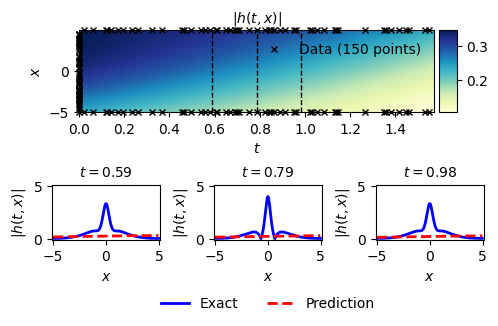

In [23]:
pinnstf2.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out')